<a href="https://colab.research.google.com/github/Nedu21/Pytorch-deep-learning-projects-/blob/main/Image_Classification_on_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification on Fashion-MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 50% chance to flip
    transforms.RandomRotation(10),           # Rotate between -10 and +10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))    # Always normalize *after* ToTensor
])

# Your 'val' transform stays simple
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
from torch.utils import data
# Loading the data
train_data = datasets.FashionMNIST(
    # Tells pytorch where to save data. If folder doesn't exist it creates one
    root='data',
    # Specifies you want to get the training split
    train=True,
    # Asks if data is downloaded already if no, download the dataset if yes, skip download
    download=True,
    # Converts image to pytorch tensor and scales pixel value from [0, 255] to  [0, 1]
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=val_transform
)

In [4]:
# Load the dat using the dataloader
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class CNN(nn.Module):
  def __init__(self, out_1=16, out_2=32):
    super().__init__()
    # Convolutional Layers
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.flatten = nn.Flatten()

    # Dense/Feed forward network
    self.feed_forward = nn.Sequential(
        nn.Linear((out_2*7*7), 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.flatten(x)
    x = self.feed_forward(x)
    return(x)

In [7]:
model = CNN().to(device)
print(model)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (feed_forward): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
print(len(train_dataloader))
print(len(train_dataloader.dataset))

938
60000


In [10]:
train_loss_history = []
val_loss_history = []

In [11]:
def train(dataloader, model, criterion, optimizer):
  dataset_size = len(dataloader.dataset)
  model.train()
  train_loss = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    yhat = model(X)
    loss = criterion(yhat, y)

    train_loss += loss.item() * len(X)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 200 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f'Loss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]')

  avg_train_loss = train_loss / dataset_size
  train_loss_history.append(avg_train_loss)
  print(f'Train Error: \n Avg Test Loss: {avg_train_loss:>7f}')

In [12]:
def test(dataloader, model, criterion):
  dataset_size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      yhat = model(X)
      loss = criterion(yhat, y)
      test_loss += loss.item() * len(X)
      correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = test_loss / dataset_size
    correct /= dataset_size
    val_loss_history.append(avg_test_loss)
    print(f'Test Error: \n Accuracy: {100*correct:>0.2f}% Avg Test Loss: {avg_test_loss:>7f}\n')

In [13]:
epochs = 10

for epoch in range(epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  train(train_dataloader, model, criterion, optimizer)
  test(test_dataloader, model, criterion)
print('Done!')

Epoch 1
-------------------------------
Loss: 2.388180  [   64/60000]
Loss: 0.684158  [12864/60000]
Loss: 0.650652  [25664/60000]
Loss: 0.415209  [38464/60000]
Loss: 0.524337  [51264/60000]
Train Error: 
 Avg Test Loss: 0.588779
Test Error: 
 Accuracy: 84.70% Avg Test Loss: 0.403119

Epoch 2
-------------------------------
Loss: 0.388862  [   64/60000]
Loss: 0.456624  [12864/60000]
Loss: 0.470295  [25664/60000]
Loss: 0.553741  [38464/60000]
Loss: 0.553234  [51264/60000]
Train Error: 
 Avg Test Loss: 0.420572
Test Error: 
 Accuracy: 88.14% Avg Test Loss: 0.322087

Epoch 3
-------------------------------
Loss: 0.362810  [   64/60000]
Loss: 0.407111  [12864/60000]
Loss: 0.323483  [25664/60000]
Loss: 0.417115  [38464/60000]
Loss: 0.335412  [51264/60000]
Train Error: 
 Avg Test Loss: 0.368496
Test Error: 
 Accuracy: 88.46% Avg Test Loss: 0.315862

Epoch 4
-------------------------------
Loss: 0.318607  [   64/60000]
Loss: 0.358537  [12864/60000]
Loss: 0.485211  [25664/60000]
Loss: 0.326338 

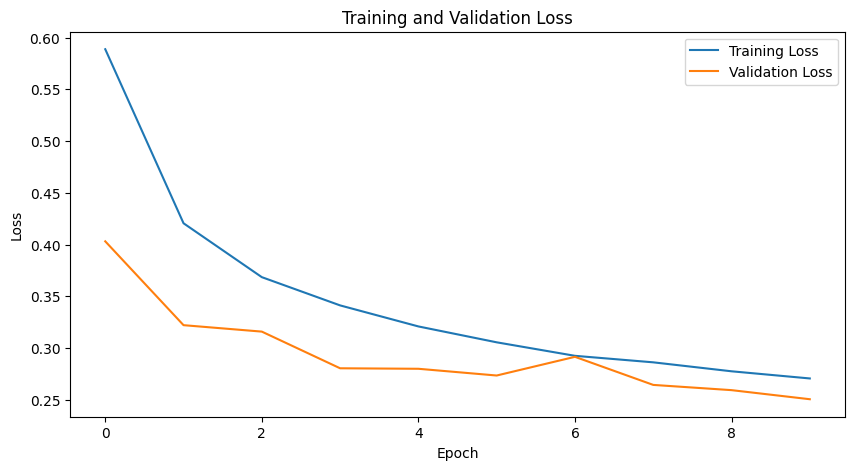

In [14]:
# Plot the losses
plt.figure(figsize=(10, 5)) # Create a figure for the plot

# Plot the training loss
plt.plot(train_loss_history, label='Training Loss')

# Plot the validation loss
plt.plot(val_loss_history, label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to show which line is which
plt.legend()

# Show the plot
plt.show()